In [50]:
import os
import matplotlib
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import xml.etree.ElementTree as ET

# mask rcnn
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.model import mold_image

%matplotlib inline

BASE_DIR = os.path.abspath(os.getcwd())

# Directory to save logs and trained model
MODEL_DIR = os.path.join(BASE_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(BASE_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
### Configuration for training on the dataset

In [66]:
class SatelliteConfig(Config):
    # Give the configuration a recognizable name
    NAME = "satellite"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
config = SatelliteConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Dataset
### Mask RCNN needs to use this dataset class

In [52]:
class SwimmingPoolDataset(utils.Dataset):
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = []
        for box in root.findall('.//bndbox'):
            xmin = int(float(box.find('xmin').text))
            ymin = int(float(box.find('ymin').text))
            xmax = int(float(box.find('xmax').text))
            ymax = int(float(box.find('ymax').text))
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract object name
        names = []
        translation = {"1": "car", "2": "swimming_pool"}
        for att in root.findall("object"):
            name = att.find("name").text
            names.append(translation[name])
            
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height, names
    
    def load_dataset(self, dataset, is_train):
        # 1 is car
        self.add_class("satellite", 1, "car")
        # 2 is swimming pool
        self.add_class("satellite", 2, "swimming_pool")
        
        images = "training_data/training_data/images/"
        annotation = "training_data/training_data/labels/"
        
        for filename in os.listdir(images):
            # exclude .jpg
            image_id = filename[:-4]
            
            img_path = images + filename
            ann_path = annotation + image_id + ".xml"
            
            # skip all images after 2623 if we are building the train set
            if is_train and int(image_id) >= 2623:
                continue
            
            # skip all images before 2623 if we are building the test/val set
            if not is_train and int(image_id) < 2623:
                continue
            
            self.add_image("satellite", image_id=image_id,
                       path=img_path,
                       annotation=ann_path)
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        
        #define box file location
        path = info["annotation"]
        #load XML
        boxes, w, h, names = self.extract_boxes(path)

        masks = np.zeros([h,w,len(boxes)], dtype="uint8")
        
        #create masks
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(names[i]))
        
        return masks, np.asarray(class_ids, dtype="int32")
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info["path"]

# Mask Demonstration

In [53]:
# split into train and test set
train = SwimmingPoolDataset()
train.load_dataset('swimming_pool', is_train = True)
train.prepare()

test = SwimmingPoolDataset()
test.load_dataset('swimming_pool', is_train = False)
test.prepare()

In [54]:
image_id = 14
image = train.load_image(image_id)
# background + 2 classifications
print("Image Shape", image.shape)

mask, class_ids = train.load_mask(image_id)
# number of masks
print("Mask Shape:", mask.shape)

Image Shape (224, 224, 3)
Mask Shape: (224, 224, 4)


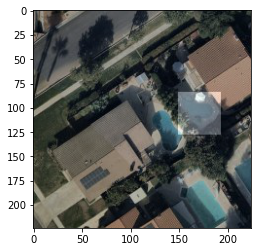

In [55]:
# show bounding box for mask
plt.imshow(image)
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
plt.show()

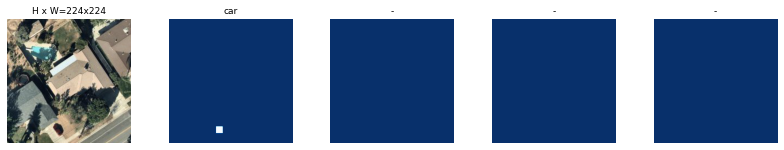

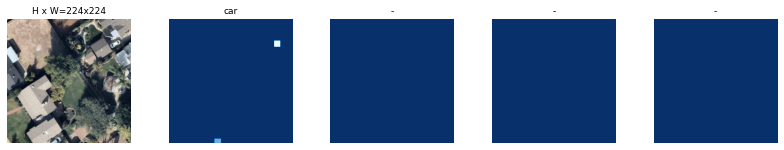

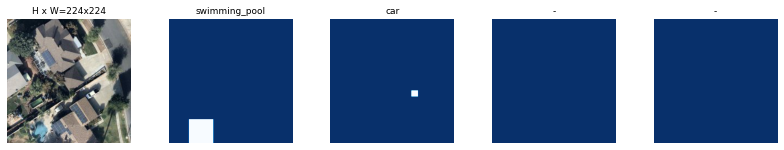

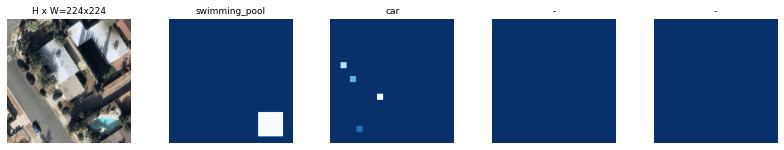

In [56]:
# get 4 random images
image_ids = np.random.choice(train.image_ids, 4)
# show bounding boxes for each mask
for image_id in image_ids:
    image = train.load_image(image_id)
    mask, class_ids = train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train.class_names)

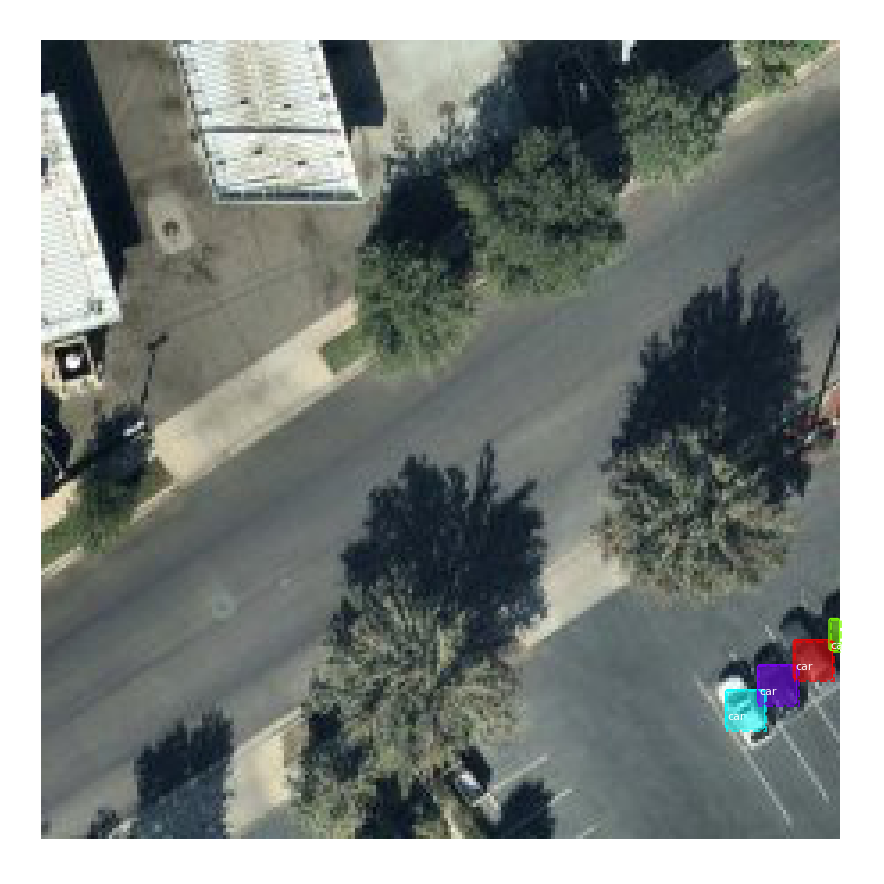

In [57]:
image_id = 3

image = train.load_image(image_id)

mask, class_ids = train.load_mask(image_id)

# get bounding boxes from the masks
bbox = utils.extract_bboxes(mask)

# display image with masks and bounding boxes
visualize.display_instances(image, bbox, mask, class_ids, train.class_names)

# Model

In [67]:
model = modellib.MaskRCNN(mode='training', config=config,
                             model_dir=MODEL_DIR)

In [68]:
init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [69]:
import tensorflow as tf
with tf.device('/gpu:0'):
    model.train(train_dataset=train, 
                val_dataset=test, 
                learning_rate=config.LEARNING_RATE, 
                epochs=1, 
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Chase Toyofuku\Documents\College\393\Final\logs\satellite20210128T0133\mask_rcnn_satellite_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  1/300 [..............................] - ETA: 27:14 - loss: 3.0625

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  2/300 [..............................] - ETA: 14:48 - loss: 2.9380

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (8.169662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning

  3/300 [..............................] - ETA: 37:35 - loss: 2.8931

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  4/300 [..............................] - ETA: 28:40 - loss: 2.8732

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  5/300 [..............................] - ETA: 23:20 - loss: 2.9780

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  6/300 [..............................] - ETA: 19:46 - loss: 2.9409

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  7/300 [..............................] - ETA: 17:13 - loss: 2.9825

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  8/300 [..............................] - ETA: 15:18 - loss: 2.8916

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  9/300 [..............................] - ETA: 13:49 - loss: 2.9126

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 10/300 [>.............................] - ETA: 12:38 - loss: 2.8894

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 11/300 [>.............................] - ETA: 11:39 - loss: 2.9794

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 12/300 [>.............................] - ETA: 10:50 - loss: 3.0066

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 13/300 [>.............................] - ETA: 10:09 - loss: 2.9922

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 14/300 [>.............................] - ETA: 9:33 - loss: 2.9236 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 15/300 [>.............................] - ETA: 9:02 - loss: 2.9168

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 16/300 [>.............................] - ETA: 8:35 - loss: 2.8982

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 17/300 [>.............................] - ETA: 8:11 - loss: 2.8549

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 18/300 [>.............................] - ETA: 7:49 - loss: 2.8414

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 19/300 [>.............................] - ETA: 7:30 - loss: 2.8240

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 20/300 [=>............................] - ETA: 7:13 - loss: 2.8080

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 21/300 [=>............................] - ETA: 6:57 - loss: 2.7995

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 22/300 [=>............................] - ETA: 6:43 - loss: 2.7661

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 23/300 [=>............................] - ETA: 6:30 - loss: 2.7495

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 24/300 [=>............................] - ETA: 6:18 - loss: 2.7434

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 25/300 [=>............................] - ETA: 6:07 - loss: 2.7364

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 26/300 [=>............................] - ETA: 5:57 - loss: 2.7264

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 27/300 [=>............................] - ETA: 5:47 - loss: 2.7068

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 28/300 [=>............................] - ETA: 5:38 - loss: 2.6918

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 29/300 [=>............................] - ETA: 5:30 - loss: 2.6776

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 30/300 [==>...........................] - ETA: 5:22 - loss: 2.6706

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 31/300 [==>...........................] - ETA: 5:15 - loss: 2.6480

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 32/300 [==>...........................] - ETA: 5:08 - loss: 2.6525

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 33/300 [==>...........................] - ETA: 5:02 - loss: 2.6312

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 34/300 [==>...........................] - ETA: 4:55 - loss: 2.6203

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 35/300 [==>...........................] - ETA: 4:50 - loss: 2.5960

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 36/300 [==>...........................] - ETA: 4:44 - loss: 2.5854

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 37/300 [==>...........................] - ETA: 4:39 - loss: 2.5725

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 38/300 [==>...........................] - ETA: 4:34 - loss: 2.5618

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 39/300 [==>...........................] - ETA: 4:29 - loss: 2.5551

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 40/300 [===>..........................] - ETA: 4:25 - loss: 2.5477

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 41/300 [===>..........................] - ETA: 4:20 - loss: 2.5405

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 42/300 [===>..........................] - ETA: 4:16 - loss: 2.5496

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 43/300 [===>..........................] - ETA: 4:12 - loss: 2.5374

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 44/300 [===>..........................] - ETA: 4:08 - loss: 2.5476

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 45/300 [===>..........................] - ETA: 4:04 - loss: 2.5440

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 46/300 [===>..........................] - ETA: 4:01 - loss: 2.5383

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 47/300 [===>..........................] - ETA: 3:58 - loss: 2.5331

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 48/300 [===>..........................] - ETA: 3:54 - loss: 2.5246

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 49/300 [===>..........................] - ETA: 3:51 - loss: 2.5243

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 50/300 [====>.........................] - ETA: 3:48 - loss: 2.5087

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 51/300 [====>.........................] - ETA: 3:45 - loss: 2.5157

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 52/300 [====>.........................] - ETA: 3:42 - loss: 2.5064

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 53/300 [====>.........................] - ETA: 3:39 - loss: 2.4882

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 54/300 [====>.........................] - ETA: 3:37 - loss: 2.4855

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 55/300 [====>.........................] - ETA: 3:34 - loss: 2.4790

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 56/300 [====>.........................] - ETA: 3:31 - loss: 2.4868

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 57/300 [====>.........................] - ETA: 3:29 - loss: 2.4765

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 58/300 [====>.........................] - ETA: 3:27 - loss: 2.4839

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 59/300 [====>.........................] - ETA: 3:24 - loss: 2.4803

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 60/300 [=====>........................] - ETA: 3:22 - loss: 2.4671

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 61/300 [=====>........................] - ETA: 3:20 - loss: 2.4669

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 62/300 [=====>........................] - ETA: 3:17 - loss: 2.4582

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 63/300 [=====>........................] - ETA: 3:15 - loss: 2.4556

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 64/300 [=====>........................] - ETA: 3:13 - loss: 2.4497

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 65/300 [=====>........................] - ETA: 3:11 - loss: 2.4534

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 66/300 [=====>........................] - ETA: 3:09 - loss: 2.4385

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 67/300 [=====>........................] - ETA: 3:07 - loss: 2.4254

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 68/300 [=====>........................] - ETA: 3:05 - loss: 2.4178

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 69/300 [=====>........................] - ETA: 3:04 - loss: 2.4111

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 70/300 [======>.......................] - ETA: 3:02 - loss: 2.4109

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 71/300 [======>.......................] - ETA: 3:00 - loss: 2.4018

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 72/300 [======>.......................] - ETA: 2:58 - loss: 2.3900

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 73/300 [======>.......................] - ETA: 2:57 - loss: 2.3864

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 74/300 [======>.......................] - ETA: 2:55 - loss: 2.3858

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 75/300 [======>.......................] - ETA: 2:53 - loss: 2.3777

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 76/300 [======>.......................] - ETA: 2:52 - loss: 2.3775

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 77/300 [======>.......................] - ETA: 2:50 - loss: 2.3785

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 78/300 [======>.......................] - ETA: 2:49 - loss: 2.3733

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 79/300 [======>.......................] - ETA: 2:47 - loss: 2.3669

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 80/300 [=======>......................] - ETA: 2:46 - loss: 2.3597

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 81/300 [=======>......................] - ETA: 2:44 - loss: 2.3610

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 82/300 [=======>......................] - ETA: 2:43 - loss: 2.3564

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 83/300 [=======>......................] - ETA: 2:41 - loss: 2.3547

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 84/300 [=======>......................] - ETA: 2:40 - loss: 2.3469

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 85/300 [=======>......................] - ETA: 2:39 - loss: 2.3448

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 86/300 [=======>......................] - ETA: 2:37 - loss: 2.3368

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 87/300 [=======>......................] - ETA: 2:36 - loss: 2.3310

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 88/300 [=======>......................] - ETA: 2:35 - loss: 2.3217

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 89/300 [=======>......................] - ETA: 2:33 - loss: 2.3190

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 90/300 [========>.....................] - ETA: 2:32 - loss: 2.3170

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 91/300 [========>.....................] - ETA: 2:31 - loss: 2.3104

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 92/300 [========>.....................] - ETA: 2:30 - loss: 2.3077

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 93/300 [========>.....................] - ETA: 2:28 - loss: 2.3060

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 94/300 [========>.....................] - ETA: 2:27 - loss: 2.2997

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 95/300 [========>.....................] - ETA: 2:26 - loss: 2.2911

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 96/300 [========>.....................] - ETA: 2:25 - loss: 2.2879

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 97/300 [========>.....................] - ETA: 2:24 - loss: 2.2854

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 98/300 [========>.....................] - ETA: 2:22 - loss: 2.2807

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 99/300 [========>.....................] - ETA: 2:21 - loss: 2.2773

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

100/300 [=========>....................] - ETA: 2:20 - loss: 2.2741

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

101/300 [=========>....................] - ETA: 2:19 - loss: 2.2741

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

102/300 [=========>....................] - ETA: 2:18 - loss: 2.2690

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

103/300 [=========>....................] - ETA: 2:17 - loss: 2.2721

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

104/300 [=========>....................] - ETA: 2:16 - loss: 2.2692

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

105/300 [=========>....................] - ETA: 2:15 - loss: 2.2614

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

106/300 [=========>....................] - ETA: 2:14 - loss: 2.2563

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

107/300 [=========>....................] - ETA: 2:13 - loss: 2.2544

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

108/300 [=========>....................] - ETA: 2:12 - loss: 2.2488

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

109/300 [=========>....................] - ETA: 2:11 - loss: 2.2539

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

110/300 [==========>...................] - ETA: 2:10 - loss: 2.2491

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

111/300 [==========>...................] - ETA: 2:09 - loss: 2.2444

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

112/300 [==========>...................] - ETA: 2:08 - loss: 2.2448

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

113/300 [==========>...................] - ETA: 2:07 - loss: 2.2389

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

114/300 [==========>...................] - ETA: 2:06 - loss: 2.2379

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

115/300 [==========>...................] - ETA: 2:05 - loss: 2.2322

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

116/300 [==========>...................] - ETA: 2:04 - loss: 2.2314

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

117/300 [==========>...................] - ETA: 2:03 - loss: 2.2297

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

118/300 [==========>...................] - ETA: 2:02 - loss: 2.2297

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

119/300 [==========>...................] - ETA: 2:01 - loss: 2.2258

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

120/300 [===========>..................] - ETA: 2:00 - loss: 2.2242

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

121/300 [===========>..................] - ETA: 1:59 - loss: 2.2199

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

122/300 [===========>..................] - ETA: 1:58 - loss: 2.2164

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

123/300 [===========>..................] - ETA: 1:57 - loss: 2.2108

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

124/300 [===========>..................] - ETA: 1:56 - loss: 2.2038

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

125/300 [===========>..................] - ETA: 1:55 - loss: 2.1994

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

126/300 [===========>..................] - ETA: 1:55 - loss: 2.1956

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

127/300 [===========>..................] - ETA: 1:54 - loss: 2.1922

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

128/300 [===========>..................] - ETA: 1:53 - loss: 2.1885

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

129/300 [===========>..................] - ETA: 1:52 - loss: 2.1838

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

130/300 [============>.................] - ETA: 1:51 - loss: 2.1862

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

131/300 [============>.................] - ETA: 1:50 - loss: 2.1807

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

132/300 [============>.................] - ETA: 1:49 - loss: 2.1816

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

133/300 [============>.................] - ETA: 1:49 - loss: 2.1774

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

134/300 [============>.................] - ETA: 1:48 - loss: 2.1768

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

135/300 [============>.................] - ETA: 1:47 - loss: 2.1786

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

136/300 [============>.................] - ETA: 1:46 - loss: 2.1756

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

137/300 [============>.................] - ETA: 1:45 - loss: 2.1711

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

138/300 [============>.................] - ETA: 1:44 - loss: 2.1677

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

139/300 [============>.................] - ETA: 1:44 - loss: 2.1686

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

140/300 [=============>................] - ETA: 1:43 - loss: 2.1666

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

141/300 [=============>................] - ETA: 1:42 - loss: 2.1625

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

142/300 [=============>................] - ETA: 1:41 - loss: 2.1621

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

143/300 [=============>................] - ETA: 1:40 - loss: 2.1621

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

144/300 [=============>................] - ETA: 1:40 - loss: 2.1583

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

145/300 [=============>................] - ETA: 1:39 - loss: 2.1598

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

146/300 [=============>................] - ETA: 1:38 - loss: 2.1570

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

147/300 [=============>................] - ETA: 1:37 - loss: 2.1552

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

148/300 [=============>................] - ETA: 1:36 - loss: 2.1515

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

149/300 [=============>................] - ETA: 1:36 - loss: 2.1497

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

150/300 [==============>...............] - ETA: 1:35 - loss: 2.1446

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

151/300 [==============>...............] - ETA: 1:34 - loss: 2.1436

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

152/300 [==============>...............] - ETA: 1:33 - loss: 2.1420

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

153/300 [==============>...............] - ETA: 1:32 - loss: 2.1415

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

154/300 [==============>...............] - ETA: 1:32 - loss: 2.1371

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

155/300 [==============>...............] - ETA: 1:31 - loss: 2.1407

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

156/300 [==============>...............] - ETA: 1:30 - loss: 2.1381

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

157/300 [==============>...............] - ETA: 1:29 - loss: 2.1362

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

158/300 [==============>...............] - ETA: 1:29 - loss: 2.1344

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

159/300 [==============>...............] - ETA: 1:28 - loss: 2.1334

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

160/300 [===============>..............] - ETA: 1:27 - loss: 2.1292

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

161/300 [===============>..............] - ETA: 1:27 - loss: 2.1313

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

162/300 [===============>..............] - ETA: 1:26 - loss: 2.1284

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

163/300 [===============>..............] - ETA: 1:25 - loss: 2.1278

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

164/300 [===============>..............] - ETA: 1:24 - loss: 2.1261

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

165/300 [===============>..............] - ETA: 1:24 - loss: 2.1264

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

166/300 [===============>..............] - ETA: 1:23 - loss: 2.1261

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

167/300 [===============>..............] - ETA: 1:22 - loss: 2.1239

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

168/300 [===============>..............] - ETA: 1:21 - loss: 2.1202

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

169/300 [===============>..............] - ETA: 1:21 - loss: 2.1181

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

170/300 [================>.............] - ETA: 1:20 - loss: 2.1173

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

171/300 [================>.............] - ETA: 1:19 - loss: 2.1160

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

172/300 [================>.............] - ETA: 1:19 - loss: 2.1110

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

173/300 [================>.............] - ETA: 1:18 - loss: 2.1100

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

174/300 [================>.............] - ETA: 1:17 - loss: 2.1091

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

175/300 [================>.............] - ETA: 1:17 - loss: 2.1052

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

176/300 [================>.............] - ETA: 1:16 - loss: 2.1051

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

177/300 [================>.............] - ETA: 1:15 - loss: 2.1015

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

178/300 [================>.............] - ETA: 1:15 - loss: 2.1002

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

179/300 [================>.............] - ETA: 1:14 - loss: 2.0990

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

180/300 [=================>............] - ETA: 1:13 - loss: 2.0991

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

181/300 [=================>............] - ETA: 1:12 - loss: 2.0986

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

182/300 [=================>............] - ETA: 1:12 - loss: 2.0964

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

183/300 [=================>............] - ETA: 1:11 - loss: 2.0970

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

184/300 [=================>............] - ETA: 1:10 - loss: 2.0936

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

185/300 [=================>............] - ETA: 1:10 - loss: 2.0971

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

186/300 [=================>............] - ETA: 1:09 - loss: 2.0967

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

187/300 [=================>............] - ETA: 1:08 - loss: 2.0960

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

188/300 [=================>............] - ETA: 1:08 - loss: 2.0964

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

189/300 [=================>............] - ETA: 1:07 - loss: 2.0952

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

190/300 [==================>...........] - ETA: 1:06 - loss: 2.0912

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

191/300 [==================>...........] - ETA: 1:06 - loss: 2.0898

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

192/300 [==================>...........] - ETA: 1:05 - loss: 2.0887

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

193/300 [==================>...........] - ETA: 1:04 - loss: 2.0878

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

194/300 [==================>...........] - ETA: 1:04 - loss: 2.0851

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

195/300 [==================>...........] - ETA: 1:03 - loss: 2.0819

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

196/300 [==================>...........] - ETA: 1:02 - loss: 2.0794

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

197/300 [==================>...........] - ETA: 1:02 - loss: 2.0764

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

198/300 [==================>...........] - ETA: 1:01 - loss: 2.0755

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

199/300 [==================>...........] - ETA: 1:00 - loss: 2.0767

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

200/300 [===================>..........] - ETA: 1:00 - loss: 2.0761

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

201/300 [===================>..........] - ETA: 59s - loss: 2.0742 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

202/300 [===================>..........] - ETA: 58s - loss: 2.0731

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

203/300 [===================>..........] - ETA: 58s - loss: 2.0713

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

204/300 [===================>..........] - ETA: 57s - loss: 2.0680

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

205/300 [===================>..........] - ETA: 57s - loss: 2.0656

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

206/300 [===================>..........] - ETA: 56s - loss: 2.0636

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

207/300 [===================>..........] - ETA: 55s - loss: 2.0599

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

208/300 [===================>..........] - ETA: 55s - loss: 2.0582

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

209/300 [===================>..........] - ETA: 54s - loss: 2.0563

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

210/300 [====================>.........] - ETA: 53s - loss: 2.0583

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

211/300 [====================>.........] - ETA: 53s - loss: 2.0557

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

212/300 [====================>.........] - ETA: 52s - loss: 2.0534

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

213/300 [====================>.........] - ETA: 51s - loss: 2.0534

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

214/300 [====================>.........] - ETA: 51s - loss: 2.0542

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

215/300 [====================>.........] - ETA: 50s - loss: 2.0529

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

216/300 [====================>.........] - ETA: 50s - loss: 2.0497

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

217/300 [====================>.........] - ETA: 49s - loss: 2.0483

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

218/300 [====================>.........] - ETA: 48s - loss: 2.0458

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

219/300 [====================>.........] - ETA: 48s - loss: 2.0443

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

220/300 [=====================>........] - ETA: 47s - loss: 2.0423

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

221/300 [=====================>........] - ETA: 46s - loss: 2.0424

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

222/300 [=====================>........] - ETA: 46s - loss: 2.0416

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

223/300 [=====================>........] - ETA: 45s - loss: 2.0399

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

224/300 [=====================>........] - ETA: 45s - loss: 2.0381

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

225/300 [=====================>........] - ETA: 44s - loss: 2.0391

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

226/300 [=====================>........] - ETA: 43s - loss: 2.0400

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

227/300 [=====================>........] - ETA: 43s - loss: 2.0368

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

228/300 [=====================>........] - ETA: 42s - loss: 2.0392

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

229/300 [=====================>........] - ETA: 41s - loss: 2.0376

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

230/300 [======================>.......] - ETA: 41s - loss: 2.0355

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

231/300 [======================>.......] - ETA: 40s - loss: 2.0327

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

232/300 [======================>.......] - ETA: 40s - loss: 2.0340

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

233/300 [======================>.......] - ETA: 39s - loss: 2.0334

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

234/300 [======================>.......] - ETA: 38s - loss: 2.0297

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

235/300 [======================>.......] - ETA: 38s - loss: 2.0274

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

236/300 [======================>.......] - ETA: 37s - loss: 2.0251

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

237/300 [======================>.......] - ETA: 36s - loss: 2.0227

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

238/300 [======================>.......] - ETA: 36s - loss: 2.0225

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

239/300 [======================>.......] - ETA: 35s - loss: 2.0213

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

240/300 [=======================>......] - ETA: 35s - loss: 2.0190

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

241/300 [=======================>......] - ETA: 34s - loss: 2.0197

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

242/300 [=======================>......] - ETA: 33s - loss: 2.0191

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

243/300 [=======================>......] - ETA: 33s - loss: 2.0178

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

244/300 [=======================>......] - ETA: 32s - loss: 2.0179

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

245/300 [=======================>......] - ETA: 32s - loss: 2.0161

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

246/300 [=======================>......] - ETA: 31s - loss: 2.0169

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

247/300 [=======================>......] - ETA: 30s - loss: 2.0149

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

248/300 [=======================>......] - ETA: 30s - loss: 2.0140

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

249/300 [=======================>......] - ETA: 29s - loss: 2.0158

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

250/300 [========================>.....] - ETA: 29s - loss: 2.0161

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

251/300 [========================>.....] - ETA: 28s - loss: 2.0157

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

252/300 [========================>.....] - ETA: 27s - loss: 2.0165

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

253/300 [========================>.....] - ETA: 27s - loss: 2.0159

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

254/300 [========================>.....] - ETA: 26s - loss: 2.0181

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

255/300 [========================>.....] - ETA: 26s - loss: 2.0167

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

256/300 [========================>.....] - ETA: 25s - loss: 2.0156

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

257/300 [========================>.....] - ETA: 24s - loss: 2.0130

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

258/300 [========================>.....] - ETA: 24s - loss: 2.0118

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

259/300 [========================>.....] - ETA: 23s - loss: 2.0110

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

260/300 [=========================>....] - ETA: 23s - loss: 2.0100

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

261/300 [=========================>....] - ETA: 22s - loss: 2.0086

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

262/300 [=========================>....] - ETA: 21s - loss: 2.0082

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

263/300 [=========================>....] - ETA: 21s - loss: 2.0084

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

264/300 [=========================>....] - ETA: 20s - loss: 2.0061

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

265/300 [=========================>....] - ETA: 20s - loss: 2.0054

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

266/300 [=========================>....] - ETA: 19s - loss: 2.0050

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

267/300 [=========================>....] - ETA: 19s - loss: 2.0035

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

268/300 [=========================>....] - ETA: 18s - loss: 2.0059

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

269/300 [=========================>....] - ETA: 17s - loss: 2.0039

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

270/300 [==========================>...] - ETA: 17s - loss: 2.0041

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

271/300 [==========================>...] - ETA: 16s - loss: 2.0041

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

272/300 [==========================>...] - ETA: 16s - loss: 2.0031

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

273/300 [==========================>...] - ETA: 15s - loss: 2.0020

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

274/300 [==========================>...] - ETA: 14s - loss: 2.0010

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

275/300 [==========================>...] - ETA: 14s - loss: 2.0000

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

276/300 [==========================>...] - ETA: 13s - loss: 1.9990

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

277/300 [==========================>...] - ETA: 13s - loss: 1.9989

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

278/300 [==========================>...] - ETA: 12s - loss: 1.9973

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

279/300 [==========================>...] - ETA: 12s - loss: 1.9977

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

280/300 [===========================>..] - ETA: 11s - loss: 1.9950

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

281/300 [===========================>..] - ETA: 10s - loss: 1.9944

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

282/300 [===========================>..] - ETA: 10s - loss: 1.9929

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

283/300 [===========================>..] - ETA: 9s - loss: 1.9908 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

284/300 [===========================>..] - ETA: 9s - loss: 1.9914

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

285/300 [===========================>..] - ETA: 8s - loss: 1.9905

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

286/300 [===========================>..] - ETA: 7s - loss: 1.9890

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

287/300 [===========================>..] - ETA: 7s - loss: 1.9895

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

288/300 [===========================>..] - ETA: 6s - loss: 1.9880

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

289/300 [===========================>..] - ETA: 6s - loss: 1.9870

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

290/300 [============================>.] - ETA: 5s - loss: 1.9869

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

291/300 [============================>.] - ETA: 5s - loss: 1.9856

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

292/300 [============================>.] - ETA: 4s - loss: 1.9840

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

293/300 [============================>.] - ETA: 3s - loss: 1.9837

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

294/300 [============================>.] - ETA: 3s - loss: 1.9832

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

295/300 [============================>.] - ETA: 2s - loss: 1.9837

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

296/300 [============================>.] - ETA: 2s - loss: 1.9838

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

297/300 [============================>.] - ETA: 1s - loss: 1.9831

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

298/300 [============================>.] - ETA: 1s - loss: 1.9816

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

299/300 [============================>.] - ETA: 0s - loss: 1.9796

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

300/300 [==============================] - 185s 616ms/step - loss: 1.9769 - val_loss: 1.8815


In [70]:
with tf.device('/gpu:0'):
    model.train(train, test, 
                learning_rate=config.LEARNING_RATE / 10,
                epochs=2, 
                layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\Chase Toyofuku\Documents\College\393\Final\logs\satellite20210128T0133\mask_rcnn_satellite_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  1/300 [..............................] - ETA: 1:50:56 - loss: 1.7952

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  2/300 [..............................] - ETA: 56:44 - loss: 1.6535  

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (15.111834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warnin

  3/300 [..............................] - ETA: 1:28:29 - loss: 1.7048

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  4/300 [..............................] - ETA: 1:06:50 - loss: 1.6673

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  5/300 [..............................] - ETA: 53:51 - loss: 1.7071  

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  6/300 [..............................] - ETA: 45:11 - loss: 1.6323

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  7/300 [..............................] - ETA: 38:59 - loss: 1.5708

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  8/300 [..............................] - ETA: 34:21 - loss: 1.5618

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  9/300 [..............................] - ETA: 30:43 - loss: 1.6615

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 10/300 [>.............................] - ETA: 27:49 - loss: 1.6511

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 11/300 [>.............................] - ETA: 25:27 - loss: 1.6301

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 12/300 [>.............................] - ETA: 23:29 - loss: 1.5971

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 13/300 [>.............................] - ETA: 21:48 - loss: 1.5727

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 14/300 [>.............................] - ETA: 20:22 - loss: 1.5797

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 15/300 [>.............................] - ETA: 19:08 - loss: 1.5634

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 16/300 [>.............................] - ETA: 18:02 - loss: 1.5384

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 17/300 [>.............................] - ETA: 17:04 - loss: 1.5420

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 18/300 [>.............................] - ETA: 16:13 - loss: 1.5371

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 19/300 [>.............................] - ETA: 15:27 - loss: 1.5923

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 20/300 [=>............................] - ETA: 14:45 - loss: 1.6081

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 21/300 [=>............................] - ETA: 14:08 - loss: 1.6409

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 22/300 [=>............................] - ETA: 13:33 - loss: 1.6463

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 23/300 [=>............................] - ETA: 13:02 - loss: 1.6276

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 24/300 [=>............................] - ETA: 12:33 - loss: 1.6266

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 25/300 [=>............................] - ETA: 12:07 - loss: 1.6124

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 26/300 [=>............................] - ETA: 11:42 - loss: 1.6158

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 27/300 [=>............................] - ETA: 11:19 - loss: 1.6040

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 28/300 [=>............................] - ETA: 10:58 - loss: 1.6171

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 29/300 [=>............................] - ETA: 10:38 - loss: 1.6157

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 30/300 [==>...........................] - ETA: 10:20 - loss: 1.6329

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 31/300 [==>...........................] - ETA: 10:03 - loss: 1.6290

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 32/300 [==>...........................] - ETA: 9:46 - loss: 1.6380 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 33/300 [==>...........................] - ETA: 9:31 - loss: 1.6350

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 34/300 [==>...........................] - ETA: 9:17 - loss: 1.6450

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 35/300 [==>...........................] - ETA: 9:03 - loss: 1.6821

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 36/300 [==>...........................] - ETA: 8:50 - loss: 1.6699

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 37/300 [==>...........................] - ETA: 8:38 - loss: 1.6699

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 38/300 [==>...........................] - ETA: 8:26 - loss: 1.6776

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 39/300 [==>...........................] - ETA: 8:15 - loss: 1.6717

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 40/300 [===>..........................] - ETA: 8:04 - loss: 1.6906

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 41/300 [===>..........................] - ETA: 7:54 - loss: 1.6951

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 42/300 [===>..........................] - ETA: 7:45 - loss: 1.7039

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 43/300 [===>..........................] - ETA: 7:36 - loss: 1.6945

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 44/300 [===>..........................] - ETA: 7:27 - loss: 1.6900

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 45/300 [===>..........................] - ETA: 7:18 - loss: 1.6815

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 46/300 [===>..........................] - ETA: 7:10 - loss: 1.6837

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 47/300 [===>..........................] - ETA: 7:02 - loss: 1.6762

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 48/300 [===>..........................] - ETA: 6:55 - loss: 1.6696

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 49/300 [===>..........................] - ETA: 6:48 - loss: 1.6619

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 50/300 [====>.........................] - ETA: 6:41 - loss: 1.6615

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 51/300 [====>.........................] - ETA: 6:34 - loss: 1.6632

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 52/300 [====>.........................] - ETA: 6:28 - loss: 1.6551

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 53/300 [====>.........................] - ETA: 6:21 - loss: 1.6522

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 54/300 [====>.........................] - ETA: 6:15 - loss: 1.6480

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 55/300 [====>.........................] - ETA: 6:10 - loss: 1.6436

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 56/300 [====>.........................] - ETA: 6:04 - loss: 1.6423

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 57/300 [====>.........................] - ETA: 5:59 - loss: 1.6437

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 58/300 [====>.........................] - ETA: 5:53 - loss: 1.6345

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 59/300 [====>.........................] - ETA: 5:48 - loss: 1.6291

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 60/300 [=====>........................] - ETA: 5:43 - loss: 1.6340

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 61/300 [=====>........................] - ETA: 5:38 - loss: 1.6331

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 62/300 [=====>........................] - ETA: 5:34 - loss: 1.6337

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 63/300 [=====>........................] - ETA: 5:29 - loss: 1.6276

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 64/300 [=====>........................] - ETA: 5:25 - loss: 1.6277

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 65/300 [=====>........................] - ETA: 5:20 - loss: 1.6299

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 66/300 [=====>........................] - ETA: 5:16 - loss: 1.6270

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 67/300 [=====>........................] - ETA: 5:12 - loss: 1.6231

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 68/300 [=====>........................] - ETA: 5:08 - loss: 1.6187

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 69/300 [=====>........................] - ETA: 5:04 - loss: 1.6249

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 70/300 [======>.......................] - ETA: 5:00 - loss: 1.6275

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 71/300 [======>.......................] - ETA: 4:57 - loss: 1.6257

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 72/300 [======>.......................] - ETA: 4:53 - loss: 1.6283

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 73/300 [======>.......................] - ETA: 4:50 - loss: 1.6250

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 74/300 [======>.......................] - ETA: 4:46 - loss: 1.6283

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 75/300 [======>.......................] - ETA: 4:43 - loss: 1.6256

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 76/300 [======>.......................] - ETA: 4:40 - loss: 1.6238

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 77/300 [======>.......................] - ETA: 4:36 - loss: 1.6198

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 78/300 [======>.......................] - ETA: 4:33 - loss: 1.6167

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 79/300 [======>.......................] - ETA: 4:30 - loss: 1.6202

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 80/300 [=======>......................] - ETA: 4:27 - loss: 1.6183

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 81/300 [=======>......................] - ETA: 4:24 - loss: 1.6130

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 82/300 [=======>......................] - ETA: 4:21 - loss: 1.6143

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 83/300 [=======>......................] - ETA: 4:18 - loss: 1.6139

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 84/300 [=======>......................] - ETA: 4:16 - loss: 1.6192

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 85/300 [=======>......................] - ETA: 4:13 - loss: 1.6199

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 86/300 [=======>......................] - ETA: 4:10 - loss: 1.6188

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 87/300 [=======>......................] - ETA: 4:08 - loss: 1.6208

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 88/300 [=======>......................] - ETA: 4:05 - loss: 1.6222

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 89/300 [=======>......................] - ETA: 4:02 - loss: 1.6231

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 90/300 [========>.....................] - ETA: 4:00 - loss: 1.6206

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 91/300 [========>.....................] - ETA: 3:57 - loss: 1.6246

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 92/300 [========>.....................] - ETA: 3:55 - loss: 1.6240

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 93/300 [========>.....................] - ETA: 3:53 - loss: 1.6280

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 94/300 [========>.....................] - ETA: 3:50 - loss: 1.6284

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 95/300 [========>.....................] - ETA: 3:48 - loss: 1.6284

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 96/300 [========>.....................] - ETA: 3:46 - loss: 1.6348

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 97/300 [========>.....................] - ETA: 3:43 - loss: 1.6318

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 98/300 [========>.....................] - ETA: 3:41 - loss: 1.6340

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 99/300 [========>.....................] - ETA: 3:39 - loss: 1.6371

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

100/300 [=========>....................] - ETA: 3:37 - loss: 1.6430

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

101/300 [=========>....................] - ETA: 3:35 - loss: 1.6413

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

102/300 [=========>....................] - ETA: 3:33 - loss: 1.6424

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

103/300 [=========>....................] - ETA: 3:31 - loss: 1.6378

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

104/300 [=========>....................] - ETA: 3:28 - loss: 1.6415

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

105/300 [=========>....................] - ETA: 3:26 - loss: 1.6373

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

106/300 [=========>....................] - ETA: 3:25 - loss: 1.6353

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

107/300 [=========>....................] - ETA: 3:23 - loss: 1.6355

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

108/300 [=========>....................] - ETA: 3:21 - loss: 1.6345

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

109/300 [=========>....................] - ETA: 3:19 - loss: 1.6340

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

110/300 [==========>...................] - ETA: 3:17 - loss: 1.6362

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

111/300 [==========>...................] - ETA: 3:15 - loss: 1.6333

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

112/300 [==========>...................] - ETA: 3:13 - loss: 1.6354

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

113/300 [==========>...................] - ETA: 3:11 - loss: 1.6360

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

114/300 [==========>...................] - ETA: 3:10 - loss: 1.6347

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

115/300 [==========>...................] - ETA: 3:08 - loss: 1.6400

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

116/300 [==========>...................] - ETA: 3:06 - loss: 1.6379

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

117/300 [==========>...................] - ETA: 3:04 - loss: 1.6421

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

118/300 [==========>...................] - ETA: 3:03 - loss: 1.6418

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

119/300 [==========>...................] - ETA: 3:01 - loss: 1.6405

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

120/300 [===========>..................] - ETA: 2:59 - loss: 1.6406

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

121/300 [===========>..................] - ETA: 2:58 - loss: 1.6378

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

122/300 [===========>..................] - ETA: 2:56 - loss: 1.6363

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

123/300 [===========>..................] - ETA: 2:55 - loss: 1.6338

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

124/300 [===========>..................] - ETA: 2:53 - loss: 1.6349

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

125/300 [===========>..................] - ETA: 2:51 - loss: 1.6352

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

126/300 [===========>..................] - ETA: 2:50 - loss: 1.6344

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

127/300 [===========>..................] - ETA: 2:48 - loss: 1.6380

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

128/300 [===========>..................] - ETA: 2:47 - loss: 1.6350

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

129/300 [===========>..................] - ETA: 2:45 - loss: 1.6354

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

130/300 [============>.................] - ETA: 2:44 - loss: 1.6335

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

131/300 [============>.................] - ETA: 2:42 - loss: 1.6320

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

132/300 [============>.................] - ETA: 2:41 - loss: 1.6280

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

133/300 [============>.................] - ETA: 2:39 - loss: 1.6293

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

134/300 [============>.................] - ETA: 2:38 - loss: 1.6253

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

135/300 [============>.................] - ETA: 2:37 - loss: 1.6224

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

136/300 [============>.................] - ETA: 2:35 - loss: 1.6228

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

137/300 [============>.................] - ETA: 2:34 - loss: 1.6195

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

138/300 [============>.................] - ETA: 2:32 - loss: 1.6189

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

139/300 [============>.................] - ETA: 2:31 - loss: 1.6221

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

140/300 [=============>................] - ETA: 2:30 - loss: 1.6183

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

141/300 [=============>................] - ETA: 2:28 - loss: 1.6193

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

142/300 [=============>................] - ETA: 2:27 - loss: 1.6184

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

143/300 [=============>................] - ETA: 2:26 - loss: 1.6194

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

144/300 [=============>................] - ETA: 2:24 - loss: 1.6265

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

145/300 [=============>................] - ETA: 2:23 - loss: 1.6259

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

146/300 [=============>................] - ETA: 2:22 - loss: 1.6285

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

147/300 [=============>................] - ETA: 2:20 - loss: 1.6283

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

148/300 [=============>................] - ETA: 2:19 - loss: 1.6288

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

149/300 [=============>................] - ETA: 2:18 - loss: 1.6310

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

150/300 [==============>...............] - ETA: 2:16 - loss: 1.6315

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

151/300 [==============>...............] - ETA: 2:15 - loss: 1.6304

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

152/300 [==============>...............] - ETA: 2:14 - loss: 1.6309

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

153/300 [==============>...............] - ETA: 2:13 - loss: 1.6286

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

154/300 [==============>...............] - ETA: 2:11 - loss: 1.6314

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

155/300 [==============>...............] - ETA: 2:10 - loss: 1.6335

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

156/300 [==============>...............] - ETA: 2:09 - loss: 1.6317

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

157/300 [==============>...............] - ETA: 2:08 - loss: 1.6309

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

158/300 [==============>...............] - ETA: 2:07 - loss: 1.6299

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

159/300 [==============>...............] - ETA: 2:05 - loss: 1.6319

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

160/300 [===============>..............] - ETA: 2:04 - loss: 1.6290

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

161/300 [===============>..............] - ETA: 2:03 - loss: 1.6307

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

162/300 [===============>..............] - ETA: 2:02 - loss: 1.6322

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

163/300 [===============>..............] - ETA: 2:01 - loss: 1.6320

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

164/300 [===============>..............] - ETA: 2:00 - loss: 1.6302

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

165/300 [===============>..............] - ETA: 1:58 - loss: 1.6282

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

166/300 [===============>..............] - ETA: 1:57 - loss: 1.6328

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

167/300 [===============>..............] - ETA: 1:56 - loss: 1.6351

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

168/300 [===============>..............] - ETA: 1:55 - loss: 1.6346

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

169/300 [===============>..............] - ETA: 1:54 - loss: 1.6358

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

170/300 [================>.............] - ETA: 1:53 - loss: 1.6352

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

171/300 [================>.............] - ETA: 1:52 - loss: 1.6340

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

172/300 [================>.............] - ETA: 1:51 - loss: 1.6358

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

173/300 [================>.............] - ETA: 1:50 - loss: 1.6360

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

174/300 [================>.............] - ETA: 1:48 - loss: 1.6360

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

175/300 [================>.............] - ETA: 1:47 - loss: 1.6359

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

176/300 [================>.............] - ETA: 1:46 - loss: 1.6366

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

177/300 [================>.............] - ETA: 1:45 - loss: 1.6357

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

178/300 [================>.............] - ETA: 1:44 - loss: 1.6358

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

179/300 [================>.............] - ETA: 1:43 - loss: 1.6359

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

180/300 [=================>............] - ETA: 1:42 - loss: 1.6357

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

181/300 [=================>............] - ETA: 1:41 - loss: 1.6361

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

182/300 [=================>............] - ETA: 1:40 - loss: 1.6390

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

183/300 [=================>............] - ETA: 1:39 - loss: 1.6368

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

184/300 [=================>............] - ETA: 1:38 - loss: 1.6368

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

185/300 [=================>............] - ETA: 1:37 - loss: 1.6354

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

186/300 [=================>............] - ETA: 1:36 - loss: 1.6333

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

187/300 [=================>............] - ETA: 1:35 - loss: 1.6322

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

188/300 [=================>............] - ETA: 1:34 - loss: 1.6319

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

189/300 [=================>............] - ETA: 1:33 - loss: 1.6314

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

190/300 [==================>...........] - ETA: 1:32 - loss: 1.6316

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

191/300 [==================>...........] - ETA: 1:31 - loss: 1.6327

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

192/300 [==================>...........] - ETA: 1:30 - loss: 1.6317

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

193/300 [==================>...........] - ETA: 1:29 - loss: 1.6320

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

194/300 [==================>...........] - ETA: 1:28 - loss: 1.6310

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

195/300 [==================>...........] - ETA: 1:27 - loss: 1.6303

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

196/300 [==================>...........] - ETA: 1:26 - loss: 1.6282

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

197/300 [==================>...........] - ETA: 1:25 - loss: 1.6268

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

198/300 [==================>...........] - ETA: 1:24 - loss: 1.6276

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

199/300 [==================>...........] - ETA: 1:23 - loss: 1.6258

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

200/300 [===================>..........] - ETA: 1:22 - loss: 1.6248

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

201/300 [===================>..........] - ETA: 1:21 - loss: 1.6248

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

202/300 [===================>..........] - ETA: 1:20 - loss: 1.6234

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

203/300 [===================>..........] - ETA: 1:19 - loss: 1.6217

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

204/300 [===================>..........] - ETA: 1:18 - loss: 1.6219

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

205/300 [===================>..........] - ETA: 1:17 - loss: 1.6201

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

206/300 [===================>..........] - ETA: 1:16 - loss: 1.6190

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

207/300 [===================>..........] - ETA: 1:16 - loss: 1.6179

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

208/300 [===================>..........] - ETA: 1:15 - loss: 1.6182

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

209/300 [===================>..........] - ETA: 1:14 - loss: 1.6204

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

210/300 [====================>.........] - ETA: 1:13 - loss: 1.6216

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

211/300 [====================>.........] - ETA: 1:12 - loss: 1.6205

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

212/300 [====================>.........] - ETA: 1:11 - loss: 1.6198

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

213/300 [====================>.........] - ETA: 1:10 - loss: 1.6193

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

214/300 [====================>.........] - ETA: 1:09 - loss: 1.6172

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

215/300 [====================>.........] - ETA: 1:08 - loss: 1.6167

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

216/300 [====================>.........] - ETA: 1:07 - loss: 1.6149

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

217/300 [====================>.........] - ETA: 1:06 - loss: 1.6149

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

218/300 [====================>.........] - ETA: 1:06 - loss: 1.6141

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

219/300 [====================>.........] - ETA: 1:05 - loss: 1.6121

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

220/300 [=====================>........] - ETA: 1:04 - loss: 1.6132

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

221/300 [=====================>........] - ETA: 1:03 - loss: 1.6117

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

222/300 [=====================>........] - ETA: 1:02 - loss: 1.6092

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

223/300 [=====================>........] - ETA: 1:01 - loss: 1.6079

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

224/300 [=====================>........] - ETA: 1:00 - loss: 1.6096

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

225/300 [=====================>........] - ETA: 59s - loss: 1.6113 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

226/300 [=====================>........] - ETA: 58s - loss: 1.6126

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

227/300 [=====================>........] - ETA: 58s - loss: 1.6110

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

228/300 [=====================>........] - ETA: 57s - loss: 1.6130

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

229/300 [=====================>........] - ETA: 56s - loss: 1.6139

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

230/300 [======================>.......] - ETA: 55s - loss: 1.6132

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

231/300 [======================>.......] - ETA: 54s - loss: 1.6148

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

232/300 [======================>.......] - ETA: 53s - loss: 1.6138

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

233/300 [======================>.......] - ETA: 52s - loss: 1.6128

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

234/300 [======================>.......] - ETA: 52s - loss: 1.6120

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

235/300 [======================>.......] - ETA: 51s - loss: 1.6116

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

236/300 [======================>.......] - ETA: 50s - loss: 1.6103

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

237/300 [======================>.......] - ETA: 49s - loss: 1.6124

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

238/300 [======================>.......] - ETA: 48s - loss: 1.6124

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

239/300 [======================>.......] - ETA: 47s - loss: 1.6122

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

240/300 [=======================>......] - ETA: 47s - loss: 1.6105

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

241/300 [=======================>......] - ETA: 46s - loss: 1.6129

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

242/300 [=======================>......] - ETA: 45s - loss: 1.6165

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

243/300 [=======================>......] - ETA: 44s - loss: 1.6176

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

244/300 [=======================>......] - ETA: 43s - loss: 1.6172

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

245/300 [=======================>......] - ETA: 42s - loss: 1.6155

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

246/300 [=======================>......] - ETA: 42s - loss: 1.6149

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

247/300 [=======================>......] - ETA: 41s - loss: 1.6153

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

248/300 [=======================>......] - ETA: 40s - loss: 1.6134

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

249/300 [=======================>......] - ETA: 39s - loss: 1.6110

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

250/300 [========================>.....] - ETA: 38s - loss: 1.6111

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

251/300 [========================>.....] - ETA: 37s - loss: 1.6105

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

252/300 [========================>.....] - ETA: 37s - loss: 1.6100

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

253/300 [========================>.....] - ETA: 36s - loss: 1.6094

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

254/300 [========================>.....] - ETA: 35s - loss: 1.6089

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

255/300 [========================>.....] - ETA: 34s - loss: 1.6088

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

256/300 [========================>.....] - ETA: 33s - loss: 1.6084

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

257/300 [========================>.....] - ETA: 33s - loss: 1.6086

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

258/300 [========================>.....] - ETA: 32s - loss: 1.6072

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

259/300 [========================>.....] - ETA: 31s - loss: 1.6078

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

260/300 [=========================>....] - ETA: 30s - loss: 1.6063

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

261/300 [=========================>....] - ETA: 29s - loss: 1.6055

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

262/300 [=========================>....] - ETA: 29s - loss: 1.6067

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

263/300 [=========================>....] - ETA: 28s - loss: 1.6075

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

264/300 [=========================>....] - ETA: 27s - loss: 1.6086

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

265/300 [=========================>....] - ETA: 26s - loss: 1.6081

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

266/300 [=========================>....] - ETA: 25s - loss: 1.6080

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

267/300 [=========================>....] - ETA: 25s - loss: 1.6061

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

268/300 [=========================>....] - ETA: 24s - loss: 1.6059

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

269/300 [=========================>....] - ETA: 23s - loss: 1.6054

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

270/300 [==========================>...] - ETA: 22s - loss: 1.6046

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

271/300 [==========================>...] - ETA: 22s - loss: 1.6049

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

272/300 [==========================>...] - ETA: 21s - loss: 1.6041

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

273/300 [==========================>...] - ETA: 20s - loss: 1.6040

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

274/300 [==========================>...] - ETA: 19s - loss: 1.6037

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

275/300 [==========================>...] - ETA: 18s - loss: 1.6037

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

276/300 [==========================>...] - ETA: 18s - loss: 1.6033

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

277/300 [==========================>...] - ETA: 17s - loss: 1.6022

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

278/300 [==========================>...] - ETA: 16s - loss: 1.6031

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

279/300 [==========================>...] - ETA: 15s - loss: 1.6035

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

280/300 [===========================>..] - ETA: 15s - loss: 1.6029

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

281/300 [===========================>..] - ETA: 14s - loss: 1.6050

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

282/300 [===========================>..] - ETA: 13s - loss: 1.6042

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

283/300 [===========================>..] - ETA: 12s - loss: 1.6047

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

284/300 [===========================>..] - ETA: 12s - loss: 1.6044

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

285/300 [===========================>..] - ETA: 11s - loss: 1.6053

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

286/300 [===========================>..] - ETA: 10s - loss: 1.6059

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

287/300 [===========================>..] - ETA: 9s - loss: 1.6069 

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

288/300 [===========================>..] - ETA: 8s - loss: 1.6058

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

289/300 [===========================>..] - ETA: 8s - loss: 1.6060

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

290/300 [============================>.] - ETA: 7s - loss: 1.6058

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

291/300 [============================>.] - ETA: 6s - loss: 1.6048

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

292/300 [============================>.] - ETA: 5s - loss: 1.6067

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

293/300 [============================>.] - ETA: 5s - loss: 1.6083

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

294/300 [============================>.] - ETA: 4s - loss: 1.6108

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

295/300 [============================>.] - ETA: 3s - loss: 1.6113

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

296/300 [============================>.] - ETA: 2s - loss: 1.6114

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

297/300 [============================>.] - ETA: 2s - loss: 1.6094

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

298/300 [============================>.] - ETA: 1s - loss: 1.6095

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

299/300 [============================>.] - ETA: 0s - loss: 1.6096

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Chase Toyofuku\anaconda3\envs\tf2\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

300/300 [==============================] - 236s 788ms/step - loss: 1.6099 - val_loss: 1.7250


# Detection

In [71]:
class InferenceConfig(SatelliteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()

model.load_weights(model_path, by_name=True)

Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:    5.00000  max:  254.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  874.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    5.00000  max:   49.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  uint8


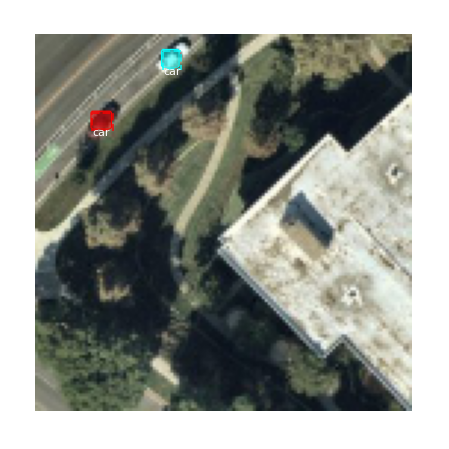

In [92]:
# Test on a random image
image_id = np.random.choice(test.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
# classification loss
log("gt_class_id", gt_class_id)
# regression loss
log("gt_bbox", gt_bbox)
# mask loss
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    5.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -118.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


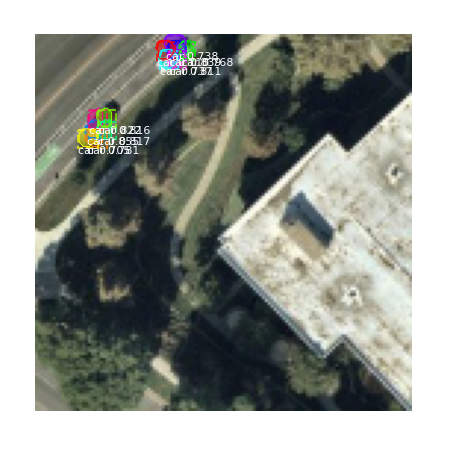

In [93]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
with tf.device('/gpu:0'):
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                test.class_names, r['scores'], ax=get_ax())

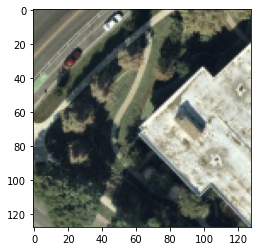

In [94]:
plt.imshow(original_image)

# Evaluate Model

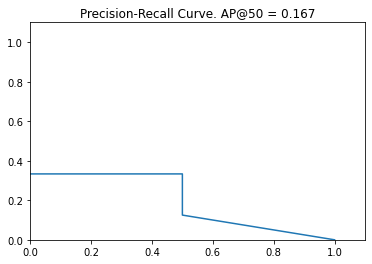

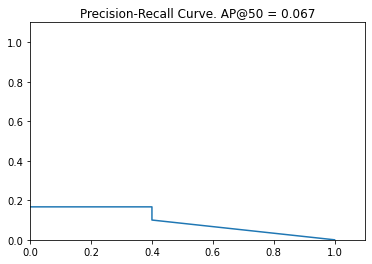

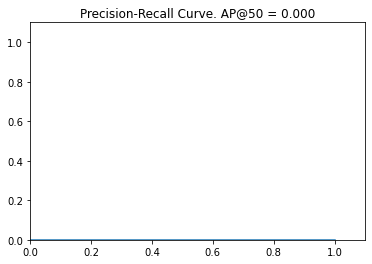

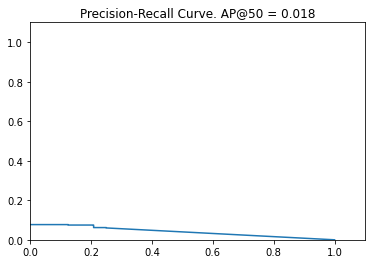

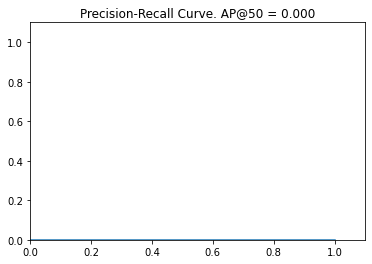

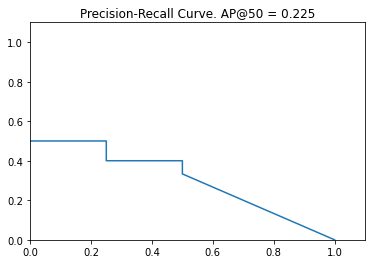

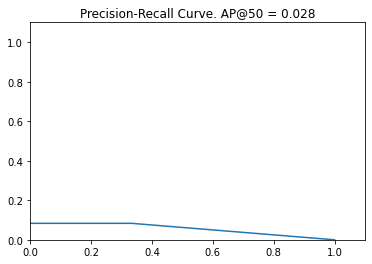

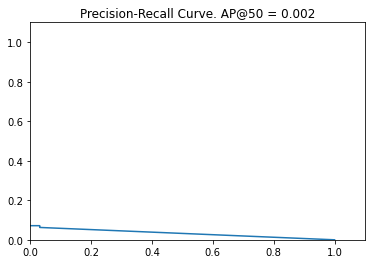

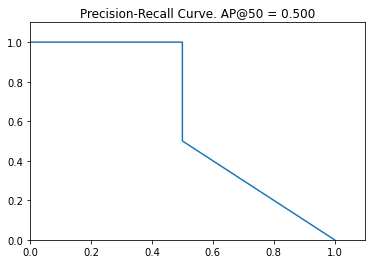

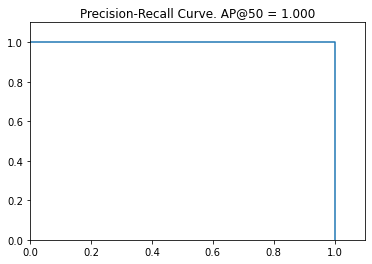

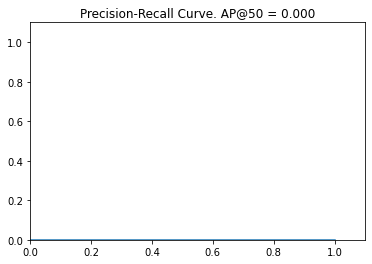

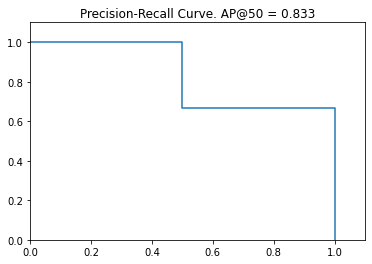

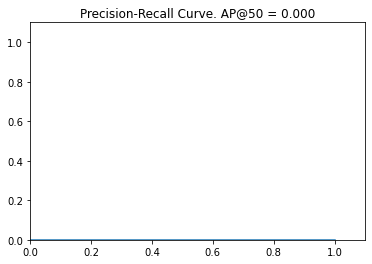

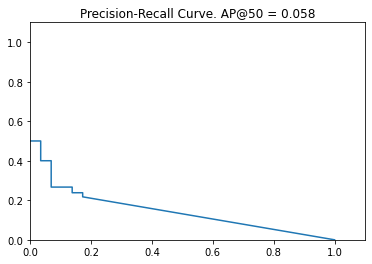

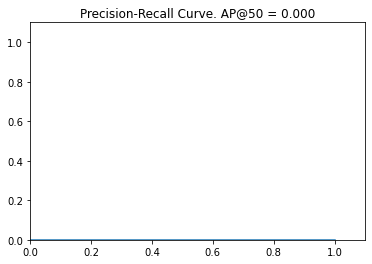

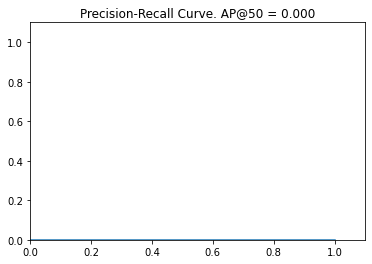

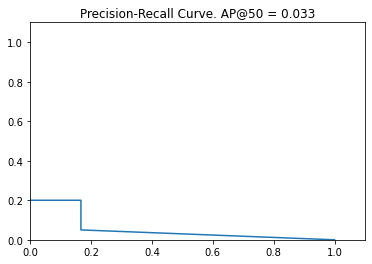

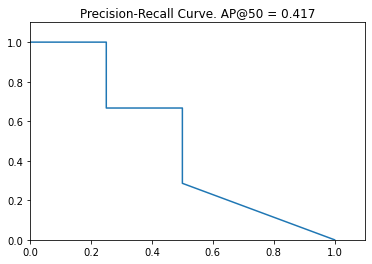

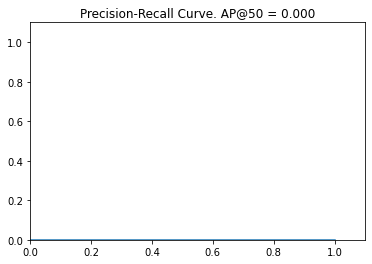

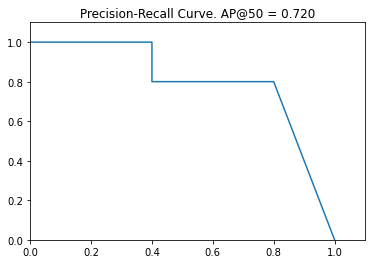

In [75]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = np.random.choice(test.image_ids, 20)
APs = []
F1s = []
precision = []
recall = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precision.append(np.mean(precisions))
    recall.append(np.mean(recalls))
    F1s.append((2* (np.mean(precisions) * np.mean(recalls)))/
                     (np.mean(precisions) + np.mean(recalls))) 
    
    visualize.plot_precision_recall(AP, precisions, recalls)

In [76]:
# mean average precision
print("mAP: ", np.mean(APs))

mAP:  0.20338618395549313


In [77]:
# average F1 Scores
print("F1: ", np.mean(F1s))

F1:  0.2126280613919566


In [78]:
# average precision Scores
print(np.mean(precision))

0.2186684509049754


In [79]:
# average recall scores
print(np.mean(recall))

0.3012101437456909


In [22]:
# 111 seconds to train with gpu, 810 seconds to train with cpu

- It gives bounding boxes and segmentation masks on each and every object leading to instance segmentation.